# Adversarial Examples

In this example, we will do the following steps:
- Generate a 1D dataset with 2 classes sampled from Gaussian Distribution with different means
- Train a Logistic Regression Classifier on this dataset
- Generate a naive Adversarial Example (i.e. Classifier thinks it's new class but example no longer looks anything remotely like the original class)
- Generate a better Adversarial Example (i.e. Classifier thinks it's new class but example still looks like original class!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

### 1. Generate Dataset

In [2]:
def generate_dataset(mu, sigma, examples):
    return np.random.normal(mu, sigma, examples)

In [3]:
mu1 = -1
mu2 = 2
sigma = 1
m = 100

def generate_full_dataset():
    x1 = generate_dataset(mu1, sigma, m)
    x2 = generate_dataset(mu2, sigma, m)
    _x = np.expand_dims(np.hstack((x1,x2)), axis=1)
    x = np.hstack((np.ones((2*m,1)), _x))
    y = np.vstack((np.zeros((m,1)), np.ones((m,1))))
    return x1, x2, x, y

x1, x2, x, y = generate_full_dataset()
_, _, test_x, test_y = generate_full_dataset()

In [4]:
def plot_distribution(mu, sigma, s, color):
    count, bins, ignored = plt.hist(s, 20, normed=True, color=color)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
        np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
        linewidth=2, color=color)

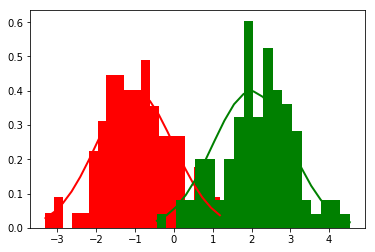

In [5]:
plot_distribution(mu1, sigma, x1, 'r')
plot_distribution(mu2, sigma, x2, 'g')
plt.show()

### 2. Train Classifier using Logistic Regression

In [6]:
def initialize_variables():
    w = np.random.randn(2,1)
    return w

def forward_prop(w, x):
    def sigmoid(z):
        return 1.0/(1 + np.exp(-z))
    return sigmoid(np.matmul(x,w))
    
def backward_prop(w, x, y, y_hat, learning_rate=0.01):
    dw = np.matmul(x.T, y_hat - y)
    w_new = w - learning_rate * dw
    return w_new

def get_class(y_hat):
    return y_hat >= 0.5

def calc_binary_cross_entropy_loss(y_hat, y):
    return -np.sum(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

def calc_accuracy(y_hat, y):
    return np.sum(y*(y_hat>=0.5) + (1-y)*(y_hat<0.5))/y.shape[0]

In [7]:
def print_performance(itr, y_hat, y, dataset_type='Train'):
    loss = calc_binary_cross_entropy_loss(y_hat, y)
    accuracy = calc_accuracy(y_hat, y)
    print('Iteration {} | {} Loss: {} | {} Accuracy: {}'.format(
        itr, dataset_type, loss, dataset_type, accuracy))
    
def training_loop(num_iters, x, y, print_every=1):
    w = initialize_variables()
    for itr in range(num_iters):
        y_hat = forward_prop(w, x)
        if itr%print_every == 0:
            print_performance(itr, y_hat, y)
        w = backward_prop(w, x, y, y_hat)
    test_y_hat = forward_prop(w, test_x)
#     print_performance('End', test_y_hat, test_y, 'Test')
    return w

In [8]:
w = training_loop(10, x, y)

Iteration 0 | Train Loss: 164.46693309520944 | Train Accuracy: 0.5
Iteration 1 | Train Loss: 32.2025858558397 | Train Accuracy: 0.935
Iteration 2 | Train Loss: 31.231327311117777 | Train Accuracy: 0.935
Iteration 3 | Train Loss: 30.46874124981169 | Train Accuracy: 0.935
Iteration 4 | Train Loss: 29.85248822421606 | Train Accuracy: 0.935
Iteration 5 | Train Loss: 29.343740443231393 | Train Accuracy: 0.935
Iteration 6 | Train Loss: 28.916736879761398 | Train Accuracy: 0.935
Iteration 7 | Train Loss: 28.553557771493992 | Train Accuracy: 0.935
Iteration 8 | Train Loss: 28.24127204034748 | Train Accuracy: 0.935
Iteration 9 | Train Loss: 27.970271568113578 | Train Accuracy: 0.94


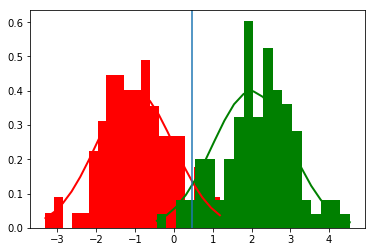

In [9]:
def find_boundary(w):
    return -w[0]/w[1]

plot_distribution(mu1, sigma, x1, 'r')
plot_distribution(mu2, sigma, x2, 'g')
plt.axvline(x=find_boundary(w))
plt.show()

### 3. Naive Adversarial Example

To generate an adversarial example w.r.t. class 0, we need to take derivatives of the loss w.r.t. an example of class 1. If we simply change the label to 0 and change the input, the classifier will classify it as class 0 eventually. However, the example no longer "looks like" it's from class 0.

In this example, we assume that to humans, any input that is negative looks like it's from class 0, while any input that is positive looks like it's from class 1.

The loss below is taken from the lecture slides. In our case, we are doing classification so we use BCE loss instead of L2 loss.

![title](img/naive_adversarial.png)

In [10]:
start_example = np.array([[1,mu2]])
y_hat = forward_prop(w, start_example)
y = np.array([[1]])
correct_loss = calc_binary_cross_entropy_loss(y_hat, y)
print("Example: {} | Class: {} | Loss: {}".format(start_example, get_class(y_hat)[0], correct_loss))

Example: [[1 2]] | Class: [ True] | Loss: 0.025447496903977174


In [11]:
y = np.array([[0]])
adversarial_loss = calc_binary_cross_entropy_loss(y_hat, y)
print("Example: {} | Adversarial Loss: {}".format(start_example, adversarial_loss))

Example: [[1 2]] | Adversarial Loss: 3.6838346606027472


In [12]:
def looks_like_original(x_new, x_orig):
    # Returns true if x_new and x_orig have same sign
    return (x_new > 0) * (x_orig > 0)

In [13]:
def backward_prop_to_input(w, x, y, y_hat, learning_rate=0.1):
    # Only works for single input x for now
    dx = np.matmul(y_hat - y, w.T)
    x_new = x - learning_rate * dx
    x_new[0][0] = 1 # zeroth feature should not get updated!
    return x_new

def print_adversarial_performance(itr, y_hat, y, x_new, x_orig, dataset_type='Train'):
    loss = calc_binary_cross_entropy_loss(y_hat, y)
    accuracy = calc_accuracy(y_hat, y)
    print('Iteration {} | {} Loss: {} | {} Accuracy: {} | New Image Looks Like Original: {}'.format(
        itr, dataset_type, loss, dataset_type, accuracy, looks_like_original(x_new, x_orig)))

In [14]:
def naive_adversarial_training_loop(x, w, num_iters, print_every=1):
    print("Starting Example: {}".format(x))
    for itr in range(num_iters):
        y_hat = forward_prop(w, x)
        if itr%print_every == 0:
            print_adversarial_performance(itr, y_hat, y, x[0][1], start_example[0][1])
        x = backward_prop_to_input(w, x, y, y_hat)
    return x

In [15]:
new_example = naive_adversarial_training_loop(start_example, w, 50, print_every=5)

Starting Example: [[1 2]]
Iteration 0 | Train Loss: 3.6838346606027472 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 5 | Train Loss: 1.3534110651616833 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 10 | Train Loss: 0.44586928330933895 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 15 | Train Loss: 0.22333954914043774 | Train Accuracy: 1.0 | New Image Looks Like Original: False
Iteration 20 | Train Loss: 0.143456511087206 | Train Accuracy: 1.0 | New Image Looks Like Original: False
Iteration 25 | Train Loss: 0.10443136635318857 | Train Accuracy: 1.0 | New Image Looks Like Original: False
Iteration 30 | Train Loss: 0.08169477341203468 | Train Accuracy: 1.0 | New Image Looks Like Original: False
Iteration 35 | Train Loss: 0.06692174954613377 | Train Accuracy: 1.0 | New Image Looks Like Original: False
Iteration 40 | Train Loss: 0.05659298383937963 | Train Accuracy: 1.0 | New Image Looks Like Original: False
Iteration 4

In [16]:
# Adversarial Example using Sign Gradient Method works!
print ("Start Example")
print("Example: {}".format(start_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(start_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, start_example))[0][0] else 0))
print()
print("Adversarial Example")
print("Example: {}".format(new_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(new_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, new_example))[0][0] else 0))

Start Example
Example: 2
Looks like Original: True
Black Box Class: 1

Adversarial Example
Example: -0.8385584344513204
Looks like Original: False
Black Box Class: 0


### 4. Better Adversarial Example

As seen in the above example, while the classifier classifies the new example as class 0, the new example no longer "looks like" the original example.

We change our loss to include the squared difference between the new example and the original example. We show that in this way, we are able to generate an adversarial example which the classifier classifies as class 0 even though the new example still "looks like" the original example.

Like before, we change the first term to BCE loss. We keep the second term the same (L2 loss over features).

![title](img/better_adversarial.png)

In [17]:
def better_backward_prop_to_input(w, x, x_orig, y, y_hat, learning_rate=0.1, lambd=1.0):
    # Only works for single input x for now
    dx = np.matmul(y_hat - y, w.T) + 2 * lambd * (x[0] - x_orig[0])
    x_new = x - learning_rate * dx
    x_new[0][0] = 1 # zeroth feature should not get updated!
    return x_new

# def calc_better_adversarial_loss(y_hat, y, x_new, x_orig, lambd=1.0):
#     return calc_binary_cross_entropy_loss(y_hat, y) + \
#             lambd * (np.square(x_new - x_orig))

In [18]:
def better_adversarial_training_loop(x, w, num_iters, print_every=1, lambd=1.0):
    print("Starting Example: {}".format(x))
    for itr in range(num_iters):
        y_hat = forward_prop(w, x)
        if itr%print_every == 0:
            print_adversarial_performance(itr, y_hat, y, x[0][1], start_example[0][1])
        x = better_backward_prop_to_input(w, x, start_example, y, y_hat, lambd=lambd)
    return x

In [19]:
new_example = better_adversarial_training_loop(start_example, w, 50, print_every=5, lambd=0.25)

Starting Example: [[1 2]]
Iteration 0 | Train Loss: 3.6838346606027472 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 5 | Train Loss: 1.5369495377266704 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 10 | Train Loss: 0.7514180035844698 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 15 | Train Loss: 0.5499689289278108 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 20 | Train Loss: 0.49015912846255727 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 25 | Train Loss: 0.4700593376221668 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 30 | Train Loss: 0.4629486863450584 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 35 | Train Loss: 0.46038417787249586 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 40 | Train Loss: 0.45945268127415007 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 45 | Trai

In [20]:
# Adversarial Example using Sign Gradient Method works!
print ("Start Example")
print("Example: {}".format(start_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(start_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, start_example))[0][0] else 0))
print()
print("Adversarial Example")
print("Example: {}".format(new_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(new_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, new_example))[0][0] else 0))

Start Example
Example: 2
Looks like Original: True
Black Box Class: 1

Adversarial Example
Example: 0.24201883671021976
Looks like Original: True
Black Box Class: 0


![title](img/space_of_adversarial_examples.png)

# Black Box vs White Box Attacks

We have seen an example of a "White Box Attack" since we have access to the original classifier's architecture and weights. Now, let's see how one may perform a "Black Box Attack".

In [22]:
# Generate dataset and forward prop in black box classifier to get corresponding labels
_gen_x = np.arange(-2,2,0.01)
gen_x = np.vstack((np.ones(_gen_x.shape), _gen_x)).T
gen_y = forward_prop(w, gen_x)

# Train our own network on generated dataset
gen_w = training_loop(10, gen_x, gen_y)

Iteration 0 | Train Loss: 252.920981783054 | Train Accuracy: 0.6159149131954049
Iteration 1 | Train Loss: 141.51855865832619 | Train Accuracy: 0.8534250366651536
Iteration 2 | Train Loss: 136.28026988788724 | Train Accuracy: 0.8565799925441653
Iteration 3 | Train Loss: 133.97567139031787 | Train Accuracy: 0.8572792278743205
Iteration 4 | Train Loss: 132.75367277756658 | Train Accuracy: 0.8575970679366708
Iteration 5 | Train Loss: 132.04248399898873 | Train Accuracy: 0.8577113450109521
Iteration 6 | Train Loss: 131.6047552658429 | Train Accuracy: 0.8577958139397198
Iteration 7 | Train Loss: 131.32503217904733 | Train Accuracy: 0.8577958139397198
Iteration 8 | Train Loss: 131.14141256561805 | Train Accuracy: 0.8578504506592182
Iteration 9 | Train Loss: 131.01843876606216 | Train Accuracy: 0.8578504506592182


In [23]:
# Create adversarial example on own network
new_example = better_adversarial_training_loop(start_example, gen_w, 50, print_every=5, lambd=0.25)

Starting Example: [[1 2]]
Iteration 0 | Train Loss: 3.5130019907812327 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 5 | Train Loss: 1.6014819059728957 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 10 | Train Loss: 0.8313043306093468 | Train Accuracy: 0.0 | New Image Looks Like Original: True
Iteration 15 | Train Loss: 0.60502368539474 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 20 | Train Loss: 0.532067738614782 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 25 | Train Loss: 0.5058422876242678 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 30 | Train Loss: 0.49591677103168713 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 35 | Train Loss: 0.49207969796297546 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 40 | Train Loss: 0.49058373867242994 | Train Accuracy: 1.0 | New Image Looks Like Original: True
Iteration 45 | Train L

In [24]:
# Adversarial Example transfers to black box classifier!
print ("Start Example")
print("Example: {}".format(start_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(start_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, start_example))[0][0] else 0))
print()
print("Adversarial Example")
print("Example: {}".format(new_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(new_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, new_example))[0][0] else 0))

Start Example
Example: 2
Looks like Original: True
Black Box Class: 1

Adversarial Example
Example: 0.2530884487558152
Looks like Original: True
Black Box Class: 0


# Targeted vs Non-Targeted Attacks

In this example, there are only 2 classes. If there are k classes, a targeted attack is trying to fool the network into thinking an example comes from a specific class j even though it "looks like" it's from class i. A non-targeted attack is trying to fool the network into thinking an example comes from any class j!=i even though it "looks like" it's from class i.

# Fast Gradient Sign Method

In the following example, we showcase the fast gradient sign method. This method comes from the insight that if we modify the input in the direction of the negative sign of the gradient of loss w.r.t. input, we can generate an adversarial example. This method works better when:
- Weights are large in magnitude
- More dimensions

In this case, we have only one dimension. Hence, we need to use eps=1.8 (pretty large) to generate the adversarial example. You can try adding more dimensions and you'll realize that a smaller eps will work there!

In [25]:
def generate_adversarial_example_using_gradient_sign_method(w, x, y, y_hat, eps=1.0):
    dx = np.matmul(y_hat - y, w.T)
    x_new = x - eps * np.sign(dx)
    x_new[0][0] = 1
    return x_new
y_hat = forward_prop(w, start_example)
new_example = generate_adversarial_example_using_gradient_sign_method(w, start_example, 0, y_hat, eps=1.8)

In [26]:
# Adversarial Example using Sign Gradient Method works!
print ("Start Example")
print("Example: {}".format(start_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(start_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, start_example))[0][0] else 0))
print()
print("Adversarial Example")
print("Example: {}".format(new_example[0][1]))
print("Looks like Original: {}".format(looks_like_original(new_example[0][1], start_example[0][1])))
print("Black Box Class: {}".format(1 if get_class(forward_prop(w, new_example))[0][0] else 0))

Start Example
Example: 2
Looks like Original: True
Black Box Class: 1

Adversarial Example
Example: 0.19999999999999996
Looks like Original: True
Black Box Class: 0
